<a href="https://colab.research.google.com/github/dniggl/Insights/blob/main/Predict_Migrations_Using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Predict human migration between countries. 

In [1]:
# Import software libraries.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Load the data into Colab.
from google.colab import files # Use to load data on Google Colab
uploaded = files.upload() # Use to load data on Google Colab


Saving migration.csv to migration.csv


In [3]:
#Store the data into a data frame. 
migration = pd.read_csv('migration.csv')

# Print the first 5 rows
migration.head(5)  

,Measure,Country,Citizenship,Year,Value
0,Arrivals,Oceania,New Zealand Citizen,1979,11817.0
1,Arrivals,Oceania,Australian Citizen,1979,4436.0
2,Arrivals,Oceania,Total All Citizenships,1979,19965.0
3,Arrivals,Antarctica,New Zealand Citizen,1979,10.0
4,Arrivals,Antarctica,Australian Citizen,1979,0.0


We obtained the migration dataset from Github. This dataset includes the following variables:  
1.   Measure - The signal type given in this row including "Arrivals", "Departures", "Net".
2.   Country - Country from where people arrived into New Zealand (for Measure = "Arrivals") or to where they left (for Measure = "Departures"). Contains special values "Not Stated" and "All countries" (grand total). 
3.   Citizenship - Citizenship of the migrants including "New Zealand Citizen", "Australian Citizen", "Total All Citizenships". 
4.   Year - Year of the measurement (arrival or departure).
5.   Value - Number of migrants.  


In [4]:
# Show information about the data columns.
migration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86526 entries, 0 to 86525
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Measure      86526 non-null  object 
 1   Country      86526 non-null  object 
 2   Citizenship  86526 non-null  object 
 3   Year         86526 non-null  int64  
 4   Value        86454 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 3.3+ MB


There are 86,526 migration records and 5 variables. The data set contains object, integer and float values. 

In [5]:
# Check for NA or missing values in features.
migration.isna().sum()

Measure         0
Country         0
Citizenship     0
Year            0
Value          72
dtype: int64

Value column has 72 fields with null or missing values. We will replace these null values with the median value. 

In [6]:
# Replace null values in Value column with the median value.  
migration["Value"].fillna(migration["Value"].median(),inplace=True)

Check for unique values in the Measure column.

In [7]:
migration['Measure'].unique()

array(['Arrivals', 'Departures', 'Net'], dtype=object)

We need to translate some catagorical data in preparation for running the machine learning model. First we will replace each of the unique string values in the Measure column with an integer value. Arrivals will have a value of 0, Departures will have a value of 1, and Net will have a value of 2.   

In [8]:
migration['Measure'].replace("Arrivals",0,inplace=True)
migration['Measure'].replace("Departures",1,inplace=True)
migration['Measure'].replace("Net",2,inplace=True)

In [9]:
# Verify value changes.
migration['Measure'].unique()

array([0, 1, 2])

Check for unique values in the Country column.

In [10]:
migration['Country'].unique()

array(['Oceania', 'Antarctica', 'American Samoa', 'Australia',
       'Cocos Islands', 'Cook Islands', 'Christmas Island', 'Fiji',
       'Micronesia', 'Guam', 'Kiribati', 'Marshall Islands',
       'Northern Mariana Islands', 'New Caledonia', 'Norfolk Island',
       'Nauru', 'Niue', 'New Zealand', 'French Polynesia',
       'Papua New Guinea', 'Pitcairn Island', 'Palau', 'Solomon Islands',
       'French Southern Territories', 'Tokelau', 'Tonga', 'Tuvalu',
       'Vanuatu', 'Wallis and Futuna', 'Samoa', 'Asia', 'Afghanistan',
       'Armenia', 'Azerbaijan', 'Bangladesh', 'Brunei Darussalam',
       'Bhutan', 'China', 'Georgia', 'Hong Kong', 'Indonesia', 'India',
       'Japan', 'Kyrgyzstan', 'Cambodia', 'North Korea', 'South Korea',
       'Kazakhstan', 'Laos', 'Sri Lanka', 'Myanmar', 'Mongolia', 'Macau',
       'Maldives', 'Malaysia', 'Nepal', 'Philippines', 'Pakistan',
       'Singapore', 'Thailand', 'Tajikistan', 'Timor-Leste',
       'Turkmenistan', 'Taiwan', 'Uzbekistan', 'Vietn

There are 253 unique countries. We will replace each of the unique string values in the Country column with an integer value. We will use the Pandas factorize method to transform the data from text to numbers. 


In [11]:
migration['Country'] = pd.factorize(migration.Country)[0]

In [12]:
# Verify value changes.
migration['Country'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

Check for unique values in the Citizenship column.

In [13]:
migration['Citizenship'].unique()


array(['New Zealand Citizen', 'Australian Citizen',
       'Total All Citizenships'], dtype=object)

There are 3 unique citizenships. We will replace each of the unique string values in the Citizenship column with an integer value. New Zealand Citizen will have a value of 0, Australian Citizen will have a value of 1, and Total All Citizenships will have a value of 2.

In [14]:
migration['Citizenship'].replace('New Zealand Citizen',0,inplace=True)
migration['Citizenship'].replace('Australian Citizen',1,inplace=True)
migration['Citizenship'].replace('Total All Citizenships',2,inplace=True)

In [15]:
# Verify value changes.
migration['Citizenship'].unique()

array([0, 1, 2])

**Visualize the correlation between variables.**

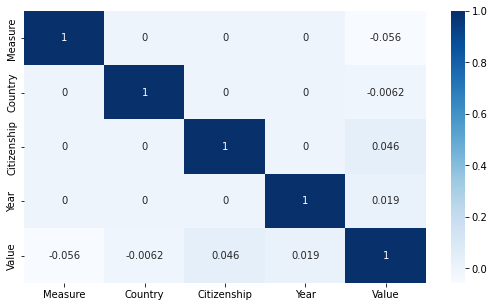

In [16]:
# Visualize the features and target variable using the correlation matrix. 
# We will use the Pearson Correlation method.
plt.figure(figsize=(9,5)) 
corr = migration.corr() 
sns.heatmap(corr, annot=True, cmap='Blues')        

We will use Measure, Country, Citizenship and Year as the feature variables. We will use Value as the target variable.

In [17]:
# Split the data into training data and test data.
# We will divide our data into x values (the data we will use to make predictions) 
# and y values (the data we are attempting to predict).
x_data = migration[['Country','Measure','Year','Citizenship']]
y_data = migration['Value']

In [18]:
# Use train_test_split function to generate training data and test data.Test data set is 30% of original data set. 
x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x_data, y_data, test_size = 0.30, random_state=9)

**We will now train, predict and evaluate the performance of the Random Forrest Regressor model.**

In [19]:
# Create model object. 
model_rf = RandomForestRegressor(n_estimators=70,max_features = 3,max_depth=5,n_jobs=-1)
# Train the model on the training data.
model_rf.fit(x_training_data, y_training_data)
# Make predictions on the test data. 
predictions_rf = model_rf.predict(x_test_data)

In [20]:
# Calculate the accuracy score.  
model_rf.score(x_test_data, y_test_data)

0.7359227553984194

The Random Forest Regressor model correctly predicted 74% of the migrations. 

Visualize the number of people who migrated between countries by year.

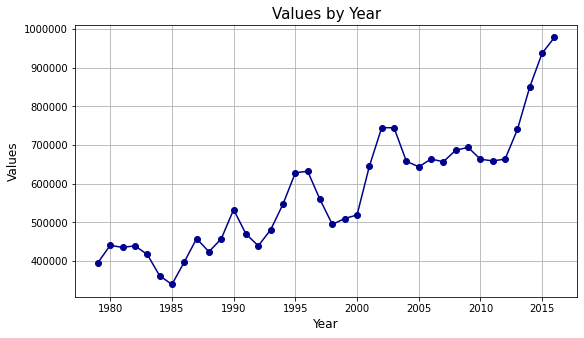

In [21]:
# Visualize number of migrations by year in a line graph.
grouped = migration.groupby(['Year']).aggregate({'Value' : 'sum'}).reset_index()
grouped = grouped.astype(int)
plt.figure(figsize=(9,5))
plt.plot(grouped['Year'], grouped['Value'], color='darkblue',  marker='o')
plt.ticklabel_format(style='plain')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Values by Year', fontsize=15)
plt.grid()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Values by Year')

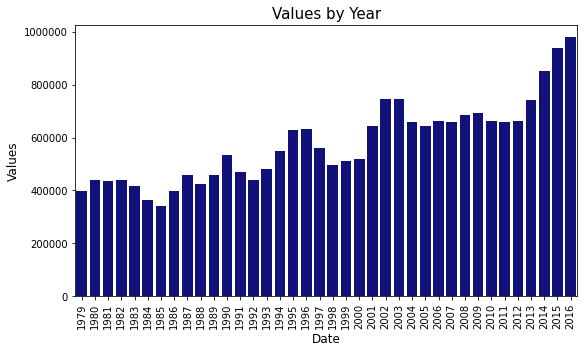

In [ ]:
# Visualize number of migrations by year in a bar plot graph.
plt.figure(figsize=(9, 5))
plt.ticklabel_format(style='plain')
ax = sns.barplot(grouped['Year'], grouped['Value'], color='darkblue')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, size = 10)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Values by Year', fontsize=15)

Conclusions: The Random Forest Regressor model correctly predicted 74% of people migrating between Countries. In general, there is a moderate  increase in the number of migrations over the time period. This finding supports what has been reported by the World Economic Forum.

The models accuracy score may be improved by having a larger dataset with more features and by tuning some of the models hyper parameters.  


